In [1]:
# Works on matplotlib 3.7.1, numpy 1.24.2, scikit-learn 1.3.1
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# Generating spiral data
theta = np.linspace(0, 3, 100)
a = 1
b = 0.5  # b is near to zero, spiral approaches a circle
r = a * np.exp(b * theta)

In [3]:
# X(+1) members of first group, centering in (c1p, c2p)
c1p = 0
c2p = 0
X1p = c1p + r * np.cos(theta * np.pi)
X2p = c2p + r * np.sin(theta * np.pi)

# X(-1) members of second group, centering in (c1n, c2n)
c1n = 1
c2n = 0
X1n = 1 - (c1n + r * np.cos(theta * np.pi))
X2n = -(c2n + r * np.sin(theta * np.pi))

In [4]:
# Aggregating data
X1 = np.concatenate((X1p, X1n))
X2 = np.concatenate((X2p, X2n))

In [5]:
# Generating noise, N(0,0.01)
e = np.random.normal(loc=0, scale=0.1, size=200)
X1 = X1 + e
X2 = X2 + e
X = np.column_stack([X2, X1])

In [6]:
# Generating indicator variable
yp = np.ones((100, 1))
yn = -np.ones((100, 1))
Y = np.vstack([yp, yn])

In [7]:
Spiral_noise = np.column_stack((X2, X1))

In [8]:
# This custom_rbf_kernel gives a simplified version of the stationary Gaussian kernel with an anisotropic radial basis.
# The simplicity comes from taking the mean of RB. The "rbf" kernel from the sklearn package can be used instead.

# Compute Radial Basis (RB)
r = 0.9  # parameter r (anisotropic Gaussian kernel). Note that if r = 0.2 in the R code, r = 0.8 in the Python code.
RB = inv(np.cov(X.T)) / (r ** 2)
gamma_value = 1 / (np.mean(RB) * 2)

def custom_rbf_kernel(X, Y=None):
    return rbf_kernel(X, Y, gamma=gamma_value)

In [9]:
# Initialize the SVC model with the custom kernel
svc_model = SVC(C=10/200, kernel=custom_rbf_kernel, probability=True)

# Fit the SVC model
svc_model.fit(Spiral_noise, Y.ravel())

# Perform 4-fold cross-validation
cv_scores = cross_val_score(svc_model, Spiral_noise, Y.ravel(), cv=4)
mean_cv_score = np.mean(cv_scores)

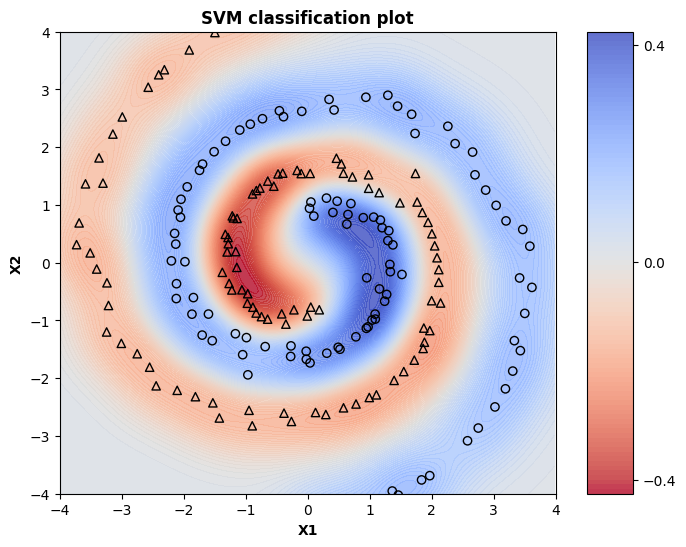

In [10]:
# Plotting
xx, yy = np.meshgrid(np.arange(-4, 4, 0.02),
                     np.arange(-4, 4, 0.02))

Z = svc_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
contourf_plot = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.8, levels=np.linspace(Z.min(), Z.max(), 100))

scatter_1 = plt.scatter(Spiral_noise[Y.ravel() == 1, 0], Spiral_noise[Y.ravel() == 1, 1], facecolors='none', edgecolors='black', marker='o', label='Class 1')
scatter_2 = plt.scatter(Spiral_noise[Y.ravel() == -1, 0], Spiral_noise[Y.ravel() == -1, 1], facecolors='none', edgecolors='black', marker='^', label='Class -1')

plt.xlim(-4, 4), plt.ylim(-4, 4)
plt.xlabel('X1', fontweight='bold'), plt.ylabel('X2', fontweight='bold'), plt.title('SVM classification plot', fontweight='bold')

colorbar = plt.colorbar(contourf_plot, aspect=10)
colorbar.set_ticks([-0.4, 0, 0.4])

plt.show()